前置作業

In [409]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from matplotlib import colors as colors
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import multivariate_normal
import seaborn as sns

data_dir = '/Users/loyichun/Downloads/Applied Mathematics and Computing for Statistics/ml_data/'
la_1 = np.loadtxt(data_dir + 'la_1.txt', comments = '%')
la_2 = np.loadtxt(data_dir + 'la_2.txt', comments = '%')
la_3 = np.loadtxt(data_dir + 'la_3.txt', comments = '%')


生成資料

In [410]:
def generate(mean, cov1, cov2, n, name, cov3 = 0):
    # mean : [[?, ?], [?, ?], [?, ?]] 
    # cov : [[?, ?], [?, ?]]
    # n : [?, ?, ?]

    if cov3 == 0 : 
        mvn1 = multivariate_normal(mean = mean[0], cov = cov1)
        mvn2 = multivariate_normal(mean = mean[1], cov = cov2)

        A, B = mvn1.rvs(n[0]), mvn2.rvs(n[1])
        x = np.vstack((A, B))
        y = np.hstack((np.zeros(n[0]), np.ones(n[1])))
        np.savetxt(data_dir + '{}.txt'.format(name), np.c_[x, y], fmt = "%.4f %.4f %d", header = "x1 y")

    else : 
        mvn1 = multivariate_normal(mean = mean[0], cov = cov1)
        mvn2 = multivariate_normal(mean = mean[1], cov = cov2)
        mvn3 = multivariate_normal(mean = mean[2], cov = cov3)

        A, B, C = mvn1.rvs(n[0]), mvn2.rvs(n[1]), mvn3.rvs(n[2])
        x = np.vstack((A, B, C))
        y = np.hstack((np.zeros(n[0]), np.ones(n[1]), np.full((n[2],), 2)))
        np.savetxt(data_dir + '{}.txt'.format(name), np.c_[x, y], fmt = "%.4f %.4f %d", header = "x1 x2 y")
        
    name = np.loadtxt(data_dir + '{}.txt'.format(name), comments = '#')
    return name


繪製圖形

In [422]:
def wang(D, method, cl, k = 0):
    global colors
    D_train, D_test = train_test_split(D, test_size = 0.2, train_size = 0.8)
    x_train = D_train[:, 0:2]
    y_train = D_train[:, 2]  
    x_test = D_test[:, 0:2]
    y_test = D_test[:, 2]
    y0, y1, y2 = x_train[y_train == 0,:], x_train[y_train == 1,:], x_train[y_train == 2,:]

    if (method == 'LDA' and cl == 2):
        plt.plot(y0[:, 0], y0[:, 1], 'o', label = 'Group A', markersize = 5, mec = 'k', c = 'orangered')
        plt.plot(y1[:, 0], y1[:, 1], 'o', label = 'Group B', markersize = 5, mec = 'k', c = 'dodgerblue')

        LDA = LinearDiscriminantAnalysis(tol = 1e-6)
        LDA.fit(x_train, y_train)
        K_train = LDA.intercept_
        L_train = LDA.coef_
        MissRate_train = round(1 - LDA.score(x_train, y_train), 4)
        f_train = lambda x_train : -L_train[0][0]/L_train[0][1] * x_train - K_train/L_train[0][1]
        x_train_dis = np.linspace(min(np.min(y0), np.min(y1)), max(np.max(y0), np.max(y1)), 100)
        plt.plot(x_train_dis, f_train(x_train_dis), label = 'discriminant')
        MissRate_test = round(1 - LDA.score(x_test, y_test), 4)
        plt.legend(framealpha = 0.5)
        print("training error : {}".format(MissRate_train))
        print("missclassification rate : {}".format(MissRate_test))
        plt.title("LDA with 2 classes")

        K = 100
        D2 = D
        LDA2 = LinearDiscriminantAnalysis(tol = 1e-6)
        LDA2.trainingErr = np.zeros(K)
        LDA2.testErr = np.zeros(K)
        for i in range(K) :
            D2_train, D2_test = train_test_split(D2, test_size = 0.2, train_size = 0.8)
            x_train_b = D2_train[:, 0:2]
            y_train_b = D2_train[:, 2]  
            x_test_b = D2_test[:, 0:2]
            y_test_b = D2_test[:, 2]
            LDA2.fit(x_train_b, y_train_b)
            LDA2.trainingErr[i] = 1 - LDA2.score(x_train_b, y_train_b)
            LDA2.testErr[i] = 1 - LDA2.score(x_test_b, y_test_b)
        print('training Error with bootstrapping 100 times :{:.4f}'.format(LDA2.trainingErr.mean()))
        print('missclassification with bootstrapping 100 times :{:.4f}'.format(LDA2.testErr.mean()))

    elif (method == 'QDA' and cl == 2):
        plt.plot(y0[:, 0], y0[:, 1], 'o', label = 'Group A', markersize = 5, mec = 'k', c = 'orangered')
        plt.plot(y1[:, 0], y1[:, 1], 'o', label = 'Group B', markersize = 5, mec = 'k', c = 'dodgerblue')

        QDA = QuadraticDiscriminantAnalysis(tol = 1e-6, store_covariance = True)
        QDA.fit(x_train, y_train)
        nx_train, ny_train = 100, 100
        x_train_min, x_train_max = plt.xlim()
        y_train_min, y_train_max = plt.ylim()
        x_train_dis = np.linspace(x_train_min, x_train_max, nx_train)
        y_train_dis = np.linspace(y_train_min, y_train_max, ny_train)
        xx_train, yy_train = np.meshgrid(x_train_dis, y_train_dis)
        Z_train = QDA.predict_proba(np.c_[xx_train.ravel(), yy_train.ravel()])
        Z_train = Z_train[:, 1].reshape(xx_train.shape)
        MissRate_train = round(1 - QDA.score(x_train, y_train), 4)
        MissRate_test = round(1 - QDA.score(x_test, y_test), 4)
        
        # Define pseudo colors
        cdit = {'red': [(0, 1, 1), (1, 0.7, 0.7)], 'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],\
                'blue': [(0, 0.7, 0.7), (1, 1, 1)]}
        cmap = colors.LinearSegmentedColormap('red_blue_classes', cdit)
        plt.cm.unregister_cmap('red_blue_classes')
        plt.cm.register_cmap(cmap = cmap)
        plt.pcolormesh(xx_train, yy_train, Z_train, cmap = 'red_blue_classes', norm = colors.Normalize(0., 1.),\
                        shading = 'auto', zorder = 0)
        plt.contour(xx_train, yy_train, Z_train, [0.5], colors = 'k')
        legends = [Line2D([0], [0], marker = 'o', color = 'none', label = 'Group A', markerfacecolor = 'orangered',\
                    markersize = 5),\
                   Line2D([0], [0], marker = 'o', color = 'none', label = 'Group B', markerfacecolor = 'dodgerblue',\
                    markersize = 5),\
                   Line2D([0], [0], lw = 2, color = 'k', label = 'discriminant')]
        plt.legend(handles = legends, framealpha = 0.5)
        print("training error : {}".format(MissRate_train))
        print("missclassification rate : {}".format(MissRate_test))
        plt.title("QDA with 2 classes")

        K = 100
        D2 = D
        QDA2 = QuadraticDiscriminantAnalysis(tol = 1e-6, store_covariance = True)
        QDA2.trainingErr = np.zeros(K)
        QDA2.testErr = np.zeros(K)
        for i in range(K) :
            D2_train, D2_test = train_test_split(D2, test_size = 0.2, train_size = 0.8)
            x_train_b = D2_train[:, 0:2]
            y_train_b = D2_train[:, 2]  
            x_test_b = D2_test[:, 0:2]
            y_test_b = D2_test[:, 2]
            QDA2.fit(x_train_b, y_train_b)
            QDA2.trainingErr[i] = 1 - QDA2.score(x_train_b, y_train_b)
            QDA2.testErr[i] = 1 - QDA2.score(x_test_b, y_test_b)
        print('training Error with bootstrapping 100 times :{:.4f}'.format(QDA2.trainingErr.mean()))
        print('missclassification with bootstrapping 100 times :{:.4f}'.format(QDA2.testErr.mean()))

    elif (method == 'LDA' and cl == 3):
        plt.plot(y0[:, 0], y0[:, 1], 'o', label = 'Group A', markersize = 5, mec = 'k', c = 'orangered')
        plt.plot(y1[:, 0], y1[:, 1], 'o', label = 'Group B', markersize = 5, mec = 'k', c = 'dodgerblue')
        plt.plot(y2[:, 0], y2[:, 1], 'go', label = 'Group C', markersize = 5, mec = 'k')

        LDA = LinearDiscriminantAnalysis(tol = 1e-6)
        LDA.fit(x_train, y_train)
        MissRate_train = round(1 - LDA.score(x_train, y_train), 4)
        MissRate_test = round(1 - LDA.score(x_test, y_test), 4)
        nx_train, ny_train = 500, 500
        x_train_min, x_train_max = plt.xlim()
        y_train_min, y_train_max = plt.ylim()
        x_train_dis = np.linspace(x_train_min, x_train_max, nx_train)
        y_train_dis = np.linspace(y_train_min, y_train_max, ny_train)
        xx_train, yy_train = np.meshgrid(x_train_dis, y_train_dis)
        x1_train, x2_train = xx_train.ravel(), yy_train.ravel()
        ZLDA = LDA.predict_proba(np.c_[x1_train, x2_train])
        zz = LDA.predict(np.c_[x1_train, x2_train])
        colors_area = ['r','b','g']
        colors = ['#FFE4E1', '#F0F8FF', '#F0FFF0']
        for i in range (cl):
            tmp = ZLDA[:, i].reshape(xx_train.shape)
            plt.scatter(x1_train[zz == i], x2_train[zz == i], marker = '.', c = colors[i])
        legends = [Line2D([0], [0], marker = 'o', color = 'none', label = 'Group A', markerfacecolor = 'orangered',\
                    markersize = 5),\
                   Line2D([0], [0], marker = 'o', color = 'none', label = 'Group B', markerfacecolor = 'dodgerblue',\
                    markersize = 5),\
                   Line2D([0], [0], marker = 'o', color = 'none', label = 'Group C', markerfacecolor = 'g',\
                    markersize = 5)]
        plt.legend(handles = legends, framealpha = 0.5)
        print("training error : {}".format(MissRate_train))
        print("missclassification rate : {}".format(MissRate_test))
        plt.title("LDA with 3 classes")

        K = 100
        D2 = D
        LDA2 = LinearDiscriminantAnalysis(tol = 1e-6)
        LDA2.trainingErr = np.zeros(K)
        LDA2.testErr = np.zeros(K)
        for i in range(K) :
            D2_train, D2_test = train_test_split(D2, test_size = 0.2, train_size = 0.8)
            x_train_b = D2_train[:, 0:2]
            y_train_b = D2_train[:, 2]  
            x_test_b = D2_test[:, 0:2]
            y_test_b = D2_test[:, 2]
            LDA2.fit(x_train_b, y_train_b)
            LDA2.trainingErr[i] = 1 - LDA2.score(x_train_b, y_train_b)
            LDA2.testErr[i] = 1 - LDA2.score(x_test_b, y_test_b)
        print('training Error with bootstrapping 100 times :{:.4f}'.format(LDA2.trainingErr.mean()))
        print('missclassification with bootstrapping 100 times :{:.4f}'.format(LDA2.testErr.mean()))

    elif (method == 'QDA' and cl == 3):
        _, ax = plt.subplots()
        plt.plot(y0[:, 0], y0[:, 1], 'o', label = 'Group A', markersize = 5, mec = 'k', c = 'orangered')
        plt.plot(y1[:, 0], y1[:, 1], 'o', label = 'Group B', markersize = 5, mec = 'k', c = 'dodgerblue')
        plt.plot(y2[:, 0], y2[:, 1], 'go', label = 'Group C', markersize = 5, mec = 'k')

        QDA = QuadraticDiscriminantAnalysis(tol = 1e-6, store_covariance = True)
        QDA.fit(x_train, y_train)
        MissRate_train = round(1 - QDA.score(x_train, y_train), 4)
        MissRate_test = round(1 - QDA.score(x_test, y_test), 4)
        nx_train, ny_train = 250, 250
        x_train_min, x_train_max = plt.xlim()
        y_train_min, y_train_max = plt.ylim()
        x_train_dis = np.linspace(x_train_min, x_train_max, nx_train)
        y_train_dis = np.linspace(y_train_min, y_train_max, ny_train)
        xx_train, yy_train = np.meshgrid(x_train_dis, y_train_dis)
        x1_train, x2_train = xx_train.ravel(), yy_train.ravel()
        ZLDA = QDA.predict_proba(np.c_[x1_train, x2_train])
        zz = QDA.predict(np.c_[x1_train, x2_train])
        colors_area = ['r','b','g']
        colors = ['#FFE4E1', '#F0F8FF', '#F0FFF0']
        for i in range (cl):
            tmp = ZLDA[:, i].reshape(xx_train.shape)
            plt.contour(xx_train, yy_train, tmp, [0.5], colors = colors_area[i])
            plt.scatter(x1_train[zz == i], x2_train[zz == i], marker = '.', c = colors[i])
        legends = [Line2D([0], [0], marker = 'o', color = 'none', label = 'Group A', markerfacecolor = 'orangered',\
                    markersize = 5),\
                   Line2D([0], [0], marker = 'o', color = 'none', label = 'Group B', markerfacecolor = 'dodgerblue',\
                    markersize = 5),\
                   Line2D([0], [0], marker = 'o', color = 'none', label = 'Group C', markerfacecolor = 'g',\
                    markersize = 5),\
                   Line2D([0], [0], lw = 2, color = 'r', label = 'discriminant'),\
                   Line2D([0], [0], lw = 2, color = 'b', label = 'discriminant'),\
                   Line2D([0], [0], lw = 2, color = 'g', label = 'discriminant')]
        plt.legend(handles = legends, framealpha = 0.5)
        print("training error : {}".format(MissRate_train))
        print("missclassification rate : {}".format(MissRate_test))
        plt.title("QDA with 3 classes")

        K = 100
        D2 = D
        QDA2 = LinearDiscriminantAnalysis(tol = 1e-6)
        QDA2.trainingErr = np.zeros(K)
        QDA2.testErr = np.zeros(K)
        for i in range(K) :
            D2_train, D2_test = train_test_split(D2, test_size = 0.2, train_size = 0.8)
            x_train_b = D2_train[:, 0:2]
            y_train_b = D2_train[:, 2]  
            x_test_b = D2_test[:, 0:2]
            y_test_b = D2_test[:, 2]
            QDA2.fit(x_train_b, y_train_b)
            QDA2.trainingErr[i] = 1 - QDA2.score(x_train_b, y_train_b)
            QDA2.testErr[i] = 1 - QDA2.score(x_test_b, y_test_b)
        print('training Error with bootstrapping 100 times :{:.4f}'.format(QDA2.trainingErr.mean()))
        print('missclassification with bootstrapping 100 times :{:.4f}'.format(QDA2.testErr.mean()))
    
    elif ((method == 'LDAvsQDA' or method == 'QDAvsLDA') and cl == 2):
        plt.plot(y0[:, 0], y0[:, 1], 'o', label = 'Group A', markersize = 5, mec = 'k', c = 'orangered')
        plt.plot(y1[:, 0], y1[:, 1], 'o', label = 'Group B', markersize = 5, mec = 'k', c = 'dodgerblue')

        LDA = LinearDiscriminantAnalysis(tol = 1e-6)
        LDA.fit(x_train, y_train)
        K_train = LDA.intercept_
        L_train = LDA.coef_
        MissRate_train_l = round(1 - LDA.score(x_train, y_train), 4)
        f_train = lambda x_train : -L_train[0][0]/L_train[0][1] * x_train - K_train/L_train[0][1]
        x_train_dis_l = np.linspace(min(np.min(y0), np.min(y1)), max(np.max(y0), np.max(y1)), 100)
        plt.plot(x_train_dis_l, f_train(x_train_dis_l), label = 'discriminant of LDA')
        MissRate_test_l = round(1 - LDA.score(x_test, y_test), 4)
        print("training error of LDA: {}".format(MissRate_train_l))
        print("missclassification rate of LDA: {}".format(MissRate_test_l))

        K = 100
        D2 = D
        LDA2 = LinearDiscriminantAnalysis(tol = 1e-6)
        LDA2.trainingErr = np.zeros(K)
        LDA2.testErr = np.zeros(K)
        for i in range(K) :
            D2_train, D2_test = train_test_split(D2, test_size = 0.2, train_size = 0.8)
            x_train_b = D2_train[:, 0:2]
            y_train_b = D2_train[:, 2]  
            x_test_b = D2_test[:, 0:2]
            y_test_b = D2_test[:, 2]
            LDA2.fit(x_train_b, y_train_b)
            LDA2.trainingErr[i] = 1 - LDA2.score(x_train_b, y_train_b)
            LDA2.testErr[i] = 1 - LDA2.score(x_test_b, y_test_b)
        print('training Error of LDA with bootstrapping 100 times :{:.4f}'.format(LDA2.trainingErr.mean()))
        print('missclassification of LDA with bootstrapping 100 times :{:.4f}'.format(LDA2.testErr.mean()))

        QDA = QuadraticDiscriminantAnalysis(tol = 1e-6, store_covariance = True)
        QDA.fit(x_train, y_train)
        nx_train, ny_train = 100, 100
        x_train_min, x_train_max = plt.xlim()
        y_train_min, y_train_max = plt.ylim()
        x_train_dis_q = np.linspace(x_train_min, x_train_max, nx_train)
        y_train_dis_q = np.linspace(y_train_min, y_train_max, ny_train)
        xx_train, yy_train = np.meshgrid(x_train_dis_q, y_train_dis_q)
        Z_train = QDA.predict_proba(np.c_[xx_train.ravel(), yy_train.ravel()])
        Z_train = Z_train[:, 1].reshape(xx_train.shape)
        MissRate_train_q = round(1 - QDA.score(x_train, y_train), 4)
        MissRate_test_q = round(1 - QDA.score(x_test, y_test), 4)
        print("training error of QDA: {}".format(MissRate_train_q))
        print("missclassification rate of QDA: {}".format(MissRate_test_q))

        plt.contour(xx_train, yy_train, Z_train, [0.5], colors = 'purple')

        K = 100
        D2 = D
        QDA2 = LinearDiscriminantAnalysis(tol = 1e-6)
        QDA2.trainingErr = np.zeros(K)
        QDA2.testErr = np.zeros(K)
        for i in range(K) :
            D2_train, D2_test = train_test_split(D2, test_size = 0.2, train_size = 0.8)
            x_train_b = D2_train[:, 0:2]
            y_train_b = D2_train[:, 2]  
            x_test_b = D2_test[:, 0:2]
            y_test_b = D2_test[:, 2]
            QDA2.fit(x_train_b, y_train_b)
            QDA2.trainingErr[i] = 1 - QDA2.score(x_train_b, y_train_b)
            QDA2.testErr[i] = 1 - QDA2.score(x_test_b, y_test_b)
        print('training Error of QDA with bootstrapping 100 times :{:.4f}'.format(QDA2.trainingErr.mean()))
        print('missclassification of QDA with bootstrapping 100 times :{:.4f}'.format(QDA2.testErr.mean()))

        legends = [Line2D([0], [0], marker = 'o', color = 'none', label = 'Group A', markerfacecolor = 'orangered',\
                    markersize = 5),\
                   Line2D([0], [0], marker = 'o', color = 'none', label = 'Group B', markerfacecolor = 'dodgerblue',\
                    markersize = 5),\
                   Line2D([0], [0], lw = 2, color = 'k', label = 'discriminant of LDA'),\
                   Line2D([0], [0], lw = 2, color = 'purple', label = 'discriminant of QDA')]
        plt.legend(handles = legends, framealpha = 0.5)
        plt.title("LDA vs QDA with {} classes".format(cl))
        print('training Error of LDA with bootstrapping 100 times :{:.4f}'.format(LDA2.trainingErr.mean()))
        print('missclassification of LDA with bootstrapping 100 times :{:.4f}'.format(LDA2.testErr.mean()))

    elif ((method == 'LDAvsQDA' or method == 'QDAvsLDA') and cl == 3):
        _, ax = plt.subplots()
        plt.plot(y0[:, 0], y0[:, 1], 'o', label = 'Group A', markersize = 5, mec = 'k', c = 'orangered')
        plt.plot(y1[:, 0], y1[:, 1], 'o', label = 'Group B', markersize = 5, mec = 'k', c = 'dodgerblue')
        plt.plot(y2[:, 0], y2[:, 1], 'go', label = 'Group C', markersize = 5, mec = 'k')

        LDA = LinearDiscriminantAnalysis(tol = 1e-6)
        LDA.fit(x_train, y_train)
        MissRate_train_l = round(1 - LDA.score(x_train, y_train), 4)
        MissRate_test_l = round(1 - LDA.score(x_test, y_test), 4)
        nx_train_l, ny_train_l = 500, 500
        x_train_min_l, x_train_max_l = plt.xlim()
        y_train_min_l, y_train_max_l = plt.ylim()
        x_train_dis_l = np.linspace(x_train_min_l, x_train_max_l, nx_train_l)
        y_train_dis_l = np.linspace(y_train_min_l, y_train_max_l, ny_train_l)
        xx_train_l, yy_train_l = np.meshgrid(x_train_dis_l, y_train_dis_l)
        x1_train_l, x2_train_l = xx_train_l.ravel(), yy_train_l.ravel()
        ZLDA_l = LDA.predict_proba(np.c_[x1_train_l, x2_train_l])
        zz_l = LDA.predict(np.c_[x1_train_l, x2_train_l])
        colors = ['#FFE4E1', '#F0F8FF', '#F0FFF0']
        for i in range (cl):
            tmp = ZLDA_l[:, i].reshape(xx_train_l.shape)
            plt.scatter(x1_train_l[zz_l == i], x2_train_l[zz_l == i], marker = '.', c = colors[i])
        print("training error of LDA: {}".format(MissRate_train_l))
        print("missclassification rate of LDA: {}".format(MissRate_test_l))

        K = 100
        D2 = D
        LDA2 = LinearDiscriminantAnalysis(tol = 1e-6)
        LDA2.trainingErr = np.zeros(K)
        LDA2.testErr = np.zeros(K)
        for i in range(K) :
            D2_train, D2_test = train_test_split(D2, test_size = 0.2, train_size = 0.8)
            x_train_b = D2_train[:, 0:2]
            y_train_b = D2_train[:, 2]  
            x_test_b = D2_test[:, 0:2]
            y_test_b = D2_test[:, 2]
            LDA2.fit(x_train_b, y_train_b)
            LDA2.trainingErr[i] = 1 - LDA2.score(x_train_b, y_train_b)
            LDA2.testErr[i] = 1 - LDA2.score(x_test_b, y_test_b)
        print('training Error of LDA with bootstrapping 100 times :{:.4f}'.format(LDA2.trainingErr.mean()))
        print('missclassification of LDA with bootstrapping 100 times :{:.4f}'.format(LDA2.testErr.mean()))

        QDA = QuadraticDiscriminantAnalysis(tol = 1e-6, store_covariance = True)
        QDA.fit(x_train, y_train)
        MissRate_train_q = round(1 - QDA.score(x_train, y_train), 4)
        MissRate_test_q = round(1 - QDA.score(x_test, y_test), 4)
        nx_train_q, ny_train_q = 250, 250
        x_train_min_q, x_train_max_q = plt.xlim()
        y_train_min_q, y_train_max_q = plt.ylim()
        x_train_dis_q = np.linspace(x_train_min_q, x_train_max_q, nx_train_q)
        y_train_dis_q = np.linspace(y_train_min_q, y_train_max_q, ny_train_q)
        xx_train_q, yy_train_q = np.meshgrid(x_train_dis_q, y_train_dis_q)
        x1_train_q, x2_train_q = xx_train_q.ravel(), yy_train_q.ravel()
        ZLDA_q = QDA.predict_proba(np.c_[x1_train_q, x2_train_q])
        for i in range (cl):
            tmp = ZLDA_q[:, i].reshape(xx_train_q.shape)
            plt.contour(xx_train_q, yy_train_q, tmp, [0.5], colors = 'k')
        print("training error of QDA: {}".format(MissRate_train_q))
        print("missclassification rate of QDA: {}".format(MissRate_test_q))
        
        legends = [Line2D([0], [0], marker = 'o', color = 'none', label = 'Group A', markerfacecolor = 'orangered',\
                    markersize = 5),\
                   Line2D([0], [0], marker = 'o', color = 'none', label = 'Group B', markerfacecolor = 'dodgerblue',\
                    markersize = 5),\
                   Line2D([0], [0], marker = 'o', color = 'none', label = 'Group C', markerfacecolor = 'g',\
                    markersize = 5),\
                   Line2D([0], [0], lw = 2, color = 'k', label = 'discriminant of QDA')]
        plt.legend(handles = legends, framealpha = 0.5)

        K = 100
        D2 = D
        QDA2 = LinearDiscriminantAnalysis(tol = 1e-6)
        QDA2.trainingErr = np.zeros(K)
        QDA2.testErr = np.zeros(K)
        for i in range(K) :
            D2_train, D2_test = train_test_split(D2, test_size = 0.2, train_size = 0.8)
            x_train_b = D2_train[:, 0:2]
            y_train_b = D2_train[:, 2]  
            x_test_b = D2_test[:, 0:2]
            y_test_b = D2_test[:, 2]
            QDA2.fit(x_train_b, y_train_b)
            QDA2.trainingErr[i] = 1 - QDA2.score(x_train_b, y_train_b)
            QDA2.testErr[i] = 1 - QDA2.score(x_test_b, y_test_b)
        print('training Error of QDA with bootstrapping 100 times :{:.4f}'.format(QDA2.trainingErr.mean()))
        print('missclassification of QDA with bootstrapping 100 times :{:.4f}'.format(QDA2.testErr.mean()))
        plt.title("LDA vs QDA with 3 classes")

    elif (method == 'KNN' and (cl == 2 or cl == 3) and k != 0):
        if cl == 2:
            plt.plot(y0[:, 0], y0[:, 1], 'o', label = 'Group A', markersize = 5, mec = 'k', c = 'orangered')
            plt.plot(y1[:, 0], y1[:, 1], 'o', label = 'Group B', markersize = 5, mec = 'k', c = 'dodgerblue')
        elif cl == 3:
            plt.plot(y0[:, 0], y0[:, 1], 'o', label = 'Group A', markersize = 5, mec = 'k', c = 'orangered')
            plt.plot(y1[:, 0], y1[:, 1], 'o', label = 'Group B', markersize = 5, mec = 'k', c = 'dodgerblue')
            plt.plot(y2[:, 0], y2[:, 1], 'go', label = 'Group C', markersize = 5, mec = 'k')
        
        weights = 'uniform'
        KNN = KNeighborsClassifier(k, weights = weights)
        KNN.fit(x_train, y_train)
        x_min, x_max = x_train[:,0].min() - 1, x_train[:,0].max() + 1
        y_min, y_max = x_train[:,1].min() - 1, x_train[:,1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
        z = KNN.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = z.reshape(xx.shape)
        c = ['pink', 'lightskyblue', 'palegreen']
        cmap_light = ListedColormap(c[: cl])
        plt.contourf(xx, yy, Z, cmap = cmap_light, alpha = 0.3)
        MissRate_train = round(1 - KNN.score(x_train, y_train), 4)
        MissRate_test = round(1 - KNN.score(x_test, y_test), 4)
        print("training error : {}".format(MissRate_train))
        print("missclassification rate : {}".format(MissRate_test))
        plt.title("KNN with {} classes when k = {}".format(cl, k))
        l = [Line2D([0], [0], lw = 2, color = 'k', label = 'boundary line'),\
             Line2D([0], [0], marker = 'o', color = 'none', label = 'Group A', markerfacecolor = 'orangered',\
                markersize = 5),\
             Line2D([0], [0], marker = 'o', color = 'none', label = 'Group B', markerfacecolor = 'dodgerblue',\
                markersize = 5),\
             Line2D([0], [0], marker = 'o', color = 'none', label = 'Group C', markerfacecolor = 'g',\
                markersize = 5)]
        legends = l[: cl + 1]

        K = 100
        D2 = D
        KNN2 = KNeighborsClassifier(k, weights = weights)
        KNN2.trainingErr = np.zeros(K)
        KNN2.testErr = np.zeros(K)
        for i in range(K) :
            D2_train, D2_test = train_test_split(D2, test_size = 0.2, train_size = 0.8)
            x_train_b = D2_train[:, 0:2]
            y_train_b = D2_train[:, 2]  
            x_test_b = D2_test[:, 0:2]
            y_test_b = D2_test[:, 2]
            KNN2.fit(x_train_b, y_train_b)
            KNN2.trainingErr[i] = 1 - KNN2.score(x_train_b, y_train_b)
            KNN2.testErr[i] = 1 - KNN2.score(x_test_b, y_test_b)
        
        print('training Error with bootstrapping 100 times :{:.4f}'.format(KNN2.trainingErr.mean()))
        print('missclassification with bootstrapping 100 times :{:.4f}'.format(KNN2.testErr.mean()))
        plt.legend(handles = legends, framealpha = 0.5)

    plt.show()


測試區

training error : 0.1975
missclassification rate : 0.28
training Error with bootstrapping 100 times :0.2122
missclassification with bootstrapping 100 times :0.2132


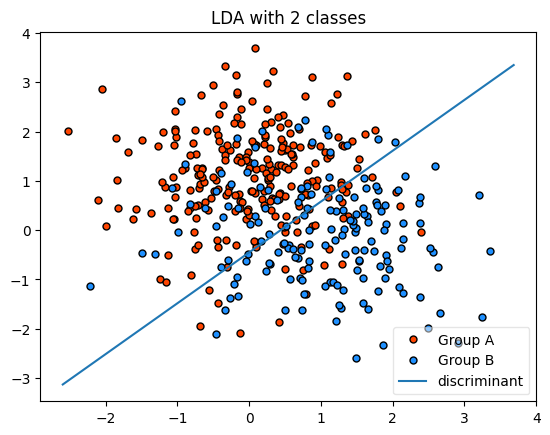

In [425]:
wang(generate([[0, 1], [1, 0]] , [[1, 0], [0, 1]], [[1, 0], [0, 1]], [300, 200], 'test'), 'LDA', 2)

la_1 : LDA